In [2]:
"""imports:"""
from  random import randint ,choice ,random ,choices , sample
import numpy as np
import copy 
from math import floor
import math
from sympy import sympify
import matplotlib.pyplot as plt
# from sklearn.metrics import mean_squared_error
# from math import inf
# import pysnooper

In [17]:
"""global variables:"""
unary_operators_list =list(["sin" , "cos" , "tan" , "exp" ])
binary_operators_list =list(["+" , "-" , "/" , "*" , "**"])

"""user's values:"""
operators_list =["+" , "-" ]*5 +\
[ "*" ]* 4 +\
["/"] *4+\
[ "sin" ,"cos" ]*3 +\
[ "**"  ]*0 +\
[ "tan"  , "exp"]*0   #user can change the quantity of operators based on function determination of complexity.
users_variables = ["x"]             #what variables our function does have
min_operatos_num = 1                #determine how many operators do we need in our function(create n operators between these 2 variables.)
max_operatos_num =7
variable_or_constant_factor = 0.3   #a factor that determines to use constant or a variale in leaf node of the tree .the closer value to 0 the more constants will appear in your function.(must be between 0 and1)
depth_or_breadth_factor = 0.5       #a factor that determines to fill both sides of the operator on not. the more closer to 0 tree will get filled in breadth not depth. (must be between 0 and1)
                                    # for example: closer to 0: (((x*10)+2)-5)/3      closer to 1: ((x*10)+2) - ((x-5)\3)
min_constant_limit = 0              #determine that constants must be in what period.
max_constant_limit =50            
num_of_population_in_a_gen = 100     #how many trees should be included in each generation.
num_of_gens =30                      #how many geneerations should be excluded
mutate_factor = 0.05                 #possiblty of mutate in children  form crossover
"""function values:"""
sample_values = {                   #user must enter some values in spots to 
    # "x" : [i for i in range(0 , 10)] ,
    "x": [x  for x in np.arange(0,10,0.1)] , 
    "outputs" : []        #can be skipped with replacing function in function below.
}
real_function_str = "x**2 + 3*x"     #what function is.

In [18]:
def fill_sample_output(func_str = real_function_str):   
    """funtion to  fill sample["output"] for 1 variable:"""
    temp_list = []
    for x_val in sample_values["x"]:
        temp_str = func_str.replace("x" , str(x_val))
        temp_val =eval(temp_str)
        # temp_val = sympify(temp_str)
        temp_list.append(temp_val)
    sample_values["outputs"]  =temp_list

In [19]:
fill_sample_output()

In [6]:
class Node():
    def __init__(self , value=None , used=0, father=None , right=None ,left=None , depth = 0 ):
        self.father =father
        self.right = right
        self.left = left
        self.depth =depth
        self.used = used
        self._value = value
        self.is_op()
        self.is_binary_op()
    
    def set_random_op(self):
        new_value= choice(operators_list)                
        self.value=new_value 
    def is_binary_op(self):
        self.is_binary = self.value in binary_operators_list
    def is_op(self  ):
        self.is_operator = self.value in operators_list
    
    @property
    def value(self):
        return self._value 
    @value.setter
    def value(self, new_value=None):
        self._value = new_value
        self.is_operator = new_value in operators_list
        self.is_binary = new_value in binary_operators_list

    def __repr__(self) -> str:
        return f"(V:{self.value} L:{self.left} R:{self.right})"
    def __str__(self) -> str:
        if self.left == None and self.right==None :                                          #constant or variable
            return str(self.value)
        elif self.value in binary_operators_list:                                            #binary operator
            return  f"({self.left} {self.value} {self.right})"
        else:                                                                                #unary operator                                        
            return f"{self.value} ({self.left}) "

In [7]:

class Tree():
    def __init__(self ,  root:Node , nodes:list , fitness = None ):
        self.root = root 
        self.nodes = list(nodes)
        self.fitness = fitness
    def remove_node(self , node:Node):  #note that should handle node's father outside of this function 
        if node.left==None:
            self.nodes.remove(node)
            pass
        else:
            self.nodes.remove(node)
            self.remove_node(node.left)
            self.remove_node(node.right) 
    
    def add_node(self , node:Node): #note that should handle node's father outside of this function
        if node.left==None:
            self.nodes.append(node)
            pass
        else:
            self.nodes.append(node)
            self.add_node(node.left)
            self.add_node(node.right)
        
    def replace_node(self ,node_to_replace:Node , node_that_will_be:Node):  
        father_node = node_to_replace.father
        target_node = copy.deepcopy(node_that_will_be)
        target_node.father = father_node
        if not father_node=="is_root": 
            if father_node.right==node_to_replace :
                father_node.right = target_node
            else:
                father_node.left = target_node
        else:
            self.root = target_node
            
        for node in self.nodes:
            if node == node_to_replace:
                self.remove_node(node)
        self.add_node(target_node)
        
    def mutate(self):
        # print("Mutated!!!")                                                                       #>>>for debugging
        node = choice(self.nodes)
        if node.left==None:
            if random()>0.2:
                node.value = randint(min_constant_limit ,max_constant_limit)
            else:
                node.value = choice(users_variables)
        else:
            node.value = choice(operators_list)    
    
    def evaluate(self  ,node:Node = None , x_val =0 ):
        try:
            if node == None:
                node = self.root
            if node.is_binary :                                                #**note that it doesnt work on unary operators yet!
                if node.value =="+":    
                    return np.add(self.evaluate(node = node.left , x_val=x_val) , self.evaluate(node = node.right , x_val=x_val))
                elif node.value == "-" :
                    return np.subtract(self.evaluate(node = node.left , x_val=x_val) , self.evaluate(node = node.right , x_val=x_val))
                elif node.value =="/":
                    right_eval = self.evaluate(node = node.right, x_val=x_val) 
                    if right_eval < 0.00001:    
                        return randint(0,1000000)
                    else:
                        return np.divide(self.evaluate(node = node.left , x_val=x_val) ,right_eval) 
                elif node.value == "*":
                    return np.multiply(self.evaluate(node = node.left , x_val=x_val) , self.evaluate(node = node.right , x_val=x_val))
                elif node.value == "**":
                    return np.power(self.evaluate(node = node.left , x_val=x_val) , self.evaluate(node = node.right , x_val=x_val))
            elif node.is_operator :
                if node.value == "sin":
                    return np.sin(self.evaluate(node = node.left , x_val=x_val))
                elif node.value == "cos":
                    return np.cos(self.evaluate(node = node.left , x_val=x_val))
                elif node.value == "tan":
                    return np.tan(self.evaluate(node = node.left , x_val=x_val))
                elif node.value == "exp":
                    return np.exp(self.evaluate(node = node.left , x_val=x_val))
            else:
                if node.value not in users_variables:
                    return np.single(node.value)
                else:
                    return np.single(x_val)
            
                return float(x_val)
        except ZeroDivisionError:
            print("handles from Tree.evaluate.")
            return -666
    
                
    def __repr__(self) -> str:
        return f"tree[ {self.root} ] "
    def __str__(self) -> str:
        return f"{self.root}"

In [8]:
def create_random_tree():
    """a function that creates a random tree based on user's variables and factors"""
    num_of_ops = randint(min_operatos_num , max_operatos_num)
    unattached_nodes =list([Node() for _ in range(num_of_ops-1)])
    root_node = Node(father="is_root",used=0 ,depth=0,value=choice(operators_list))          
    attached_nodes= list([root_node])                                                                       #a node gets attached when it has a parent

    # creating a random tree with operators:
    # print("test r:",root_node ,"n.o.o:",num_of_ops , "a:", attached_nodes , "u:" , unattached_nodes )     #>>>for logging
    while unattached_nodes !=[]:
        # print("***first loop")                                                                            #>>>for logging
        node =choice(attached_nodes)
        if node.used == 0:                                                                                  #node is binary operator.
            if node.value == None:                                                                          #sometimes it is already set in previous loop.
                node.value = choice(operators_list)            
            if node.value in binary_operators_list:
                if random()< depth_or_breadth_factor and len(unattached_nodes)>1:                           #fill both childs
                    child1 = unattached_nodes.pop()
                    child2 = unattached_nodes.pop()
                    child1.set_random_op()
                    child2.set_random_op()
                    node.left =child1
                    node.right =child2
                    child2.depth , child1.depth =node.depth +1,node.depth +1
                    child1.father , child2.father = node  , node
                    node.used = 1
                    attached_nodes.append(child1)
                    attached_nodes.append(child2)
                else:                                                                                       #fill one child
                    child = unattached_nodes.pop()
                    child.set_random_op()
                    if random()<0.5:
                        node.left = child
                    else:
                        node.right = child
                    child.depth =node.depth +1
                    node.used =1
                    child.father = node
                    attached_nodes.append(child)
            else:                                                                                          #node is unary operator.
                child = unattached_nodes.pop()
                child.set_random_op()
                node.left =child
                child.depth =node.depth +1
                node.used=1
                child.father = node
                attached_nodes.append(child)
    # print("after op nodes set: a:" ,attached_nodes ,"u:",unattached_nodes )                              #>>>for logging
    new_attached_nodes = []

    # adding values and constants to leaf nodes
    for node in attached_nodes:
        # print("in second loop; a:" ,attached_nodes ,"u:",unattached_nodes )                              #>>>for logging
        if node.right ==None :                                                                             #right node is empty  
            choose_const_or_var = random()                                                                 # **note:think that it woulld get into troubles when it comes to unary operators.
            if  choose_const_or_var>variable_or_constant_factor:                                           #fill with constant
                temp_value = randint(min_constant_limit , max_constant_limit)                                                           
                temp_node = Node(value=temp_value ,father=node , depth=node.depth+1)                        
                node.right = temp_node
                new_attached_nodes.append(temp_node)
            else:                                                                                          #fill with variable                                  
                temp_value = choice(users_variables)
                temp_node = Node(value=temp_value ,father=node , depth=node.depth+1)
                node.right = temp_node
                new_attached_nodes.append(temp_node)
        if node.left ==None :                                                                              #left node is empty
            choose_const_or_var = random()
            if choose_const_or_var>variable_or_constant_factor:                                            #fill with constant
                temp_value = randint(min_constant_limit , max_constant_limit)
                temp_node = Node(value=temp_value ,father=node , depth=node.depth+1)
                node.left = temp_node
                new_attached_nodes.append(temp_node)
            else:                                                                                          #fill with variable                                  
                temp_value = choice(users_variables)
                temp_node = Node(value=temp_value ,father=node , depth=node.depth+1)
                node.left = temp_node
                new_attached_nodes.append(temp_node)
    nodes  = list(attached_nodes + new_attached_nodes)
    # print("len:",len(nodes),"nodes:",nodes)   \n",                                                       #>>>for logging
    temp_tree = Tree(root= root_node ,nodes = nodes)
    # print( "at last a:" ,attached_nodes ,"u:",unattached_nodes )                                         #>>>for logging
    
    return temp_tree

In [9]:
def create_generation(num_of_population =num_of_population_in_a_gen ):
    """create the genaration from create_random_tree() with custom number of population."""
    trees_list_this_gen = []
    for i in range(num_of_population):
        temp_tree = create_random_tree()
        trees_list_this_gen.append(temp_tree)
    return trees_list_this_gen

In [10]:
def crossover(tree1:Tree ,tree2:Tree ):
    """a function that produces 2 children from 2 trees and rarely mutate them."""
    child_1 = copy.deepcopy(tree1)
    child_2 = copy.deepcopy(tree2)
    node_1 = choice(child_1.nodes)
    node_2 = choice(child_2.nodes)
    # print(node_1, node_2)
    child_1.replace_node(node_to_replace= node_1  , node_that_will_be=node_2)
    child_2.replace_node(node_to_replace= node_2 , node_that_will_be=node_1)
    if random()<mutate_factor or str(child_1)==str(tree1) or str(child_1)==str(tree2):
        child_1.mutate()
    if random()<mutate_factor or str(child_1)==str(tree1) or str(child_1)==str(tree2):
        child_2.mutate()
    return child_1 , child_2   


In [11]:
def roulette_wheel_selection(population , num=1 , replacing = False):

    # Computes the totallity of the population fitness
    population_fitness = sum([chromosome.fitness for chromosome in population])
    
    # Computes for each chromosome the probability 
    chromosome_probabilities = [chromosome.fitness/population_fitness for chromosome in population]
    
    # Selects one chromosome based on the computed probabilities
    # print("*",population )
    return np.random.choice(population ,p=chromosome_probabilities , replace=replacing, size=num)


def roulette_wheel_selection_negative(population , num=1 , replacing=False):

    # Computes the totallity of the population fitness
    population_fitness = sum([chromosome.fitness for chromosome in population])
    # max_fitness = max([chromosome.fitness for chromosome in population])
    
    # Computes for each chromosome the probability 
    chromosome_probabilities = [chromosome.fitness/population_fitness for chromosome in population]
    
    # Making the probabilities for a minimization problem
    chromosome_probabilities = 1 - np.array(chromosome_probabilities)
    
    # Selects one chromosome based on the computed probabilities
    return np.random.choice(population  , p=chromosome_probabilities ,replace=replacing , size=num)

In [12]:
def find_outputs_of_tree(tree:Tree):
    """a function that returns a list of answers of the tree in a list format. (uses for one tree)"""
    answers_list = []
    for x_val in sample_values["x"]:
        try:
            func_str =  str(tree).replace("x" ,str(x_val))
            # func_str =str(sympify(func_str))
            # temp_ans = eval(func_str)
            temp_ans = tree.evaluate(x_val=float(x_val) , node = tree.root)
            temp_ans = 666 if temp_ans== -np.inf or temp_ans==np.inf else temp_ans                                  #** note that it will replece +-inf with some constant value. 
            answers_list.append(temp_ans)
            # print("for logging:" , tree ,"|||",x_val , answers_list )                                               #>>>for logging
        except ZeroDivisionError:                   #because of division by zero error used this exception.
            answers_list.append(0)
        except :
            answers_list.append(0)
            # print("ambigues exception was : ", func_str  )
            # print(answers_list," , ",type(answers_list[0]))
    return answers_list

In [13]:
def find_fitness_1(functions_answers , real_answers=sample_values["outputs"]):
    """a function that returns fitness of a tree . the real function is saved in a global dictionary named sample_values["outpusts"] . fitness is 1/MSE"""
    try:
        mse =   np.square(np.subtract(real_answers , functions_answers)).mean()
        fitness = np.divide(np.single(1) ,mse)  # 1/MSE   
    except :   
        fitness=666
        print("exception was for this->\nfunction's answers : " ,functions_answers ,"\nreal answers:",real_answers ,"\n" )
    return fitness 


def find_fitness_2(functions_answers , real_answers=sample_values["outputs"]):
    """a function that returns fitness of a tree . the real function is saved in a global dictionary named sample_values["outpusts"] . fitness is -MSE"""
    try:
        fitness = np.single( np.multiply(-1 ,  np.square(np.subtract(real_answers , functions_answers)).mean()))  # -MSE
    except :   
        fitness=-666
        print("exception was for this->\nfunction's answers : " ,functions_answers ,"\nreal answers:",real_answers ,"\n" )                                                                                 
    return fitness 


In [14]:
def shift_fitness(f_list:list , trees:list):
    # max_f = np.max(f_list)
    min_f = np.min(f_list)
    for tree in trees:
        trees_f=tree.fitness 
        # tree.fitness = np.add(trees_f ,min_f)
        tree.fitness = np.subtract(trees_f , min_f)


In [15]:
def genetic_algotihm():
    """cell that handles the crossovers with functions that defined. """
    
    trees_in_gen = create_generation()                                                                               #first generation
    # for gen in range(1):
    for gen in range(num_of_gens):
        fitness_list = np.array([])   

        for tree in trees_in_gen:
            trees_func_answers = find_outputs_of_tree(tree)
            tree.fitness = find_fitness_2(trees_func_answers)
            if tree.fitness == 0.0:
                return tree
            fitness_list=np.append(fitness_list ,[tree.fitness])
        shift_fitness(fitness_list , trees_in_gen)                                                                         #for shifting fitnesses by minimum number of fitnesses                  


        trees_in_gen =  sorted(trees_in_gen,  key = lambda x: x.fitness )
        fitness_list = sorted(fitness_list)
        
        print(*[[tree ,tree.fitness] for tree in trees_in_gen] , sep="\n")                                                  ##>>>for logging
        

        # del fitness_list[:floor(0.2*num_of_population_in_a_gen)]
        # del trees_in_gen[:floor(0.2*num_of_population_in_a_gen)]
        
        new_gen = np.array([])
        
        parents_who_survive = trees_in_gen[-floor(0.2*num_of_population_in_a_gen):]
        new_gen = np.append(new_gen, parents_who_survive)
        
        for _ in range(floor(0.35*num_of_population_in_a_gen)):
            tree_1 ,tree_2= roulette_wheel_selection(population= trees_in_gen , num=2  ,replacing = False)
            child_1 , child_2 = crossover(tree_1 , tree_2)
            # print(tree_1 , tree_2 , "-->")                                                                                ##>>>for logging
            # print(child_1 , child_2 , "<--\n")
            new_gen = np.append(new_gen , child_1)
            new_gen = np.append(new_gen , child_2)
            
        new_commers_num = num_of_population_in_a_gen - len(new_gen)   
        if new_commers_num>0:
            new_commers =  create_generation(new_commers_num)
            new_gen =np.append(new_gen ,  new_commers)
        
        # print(*[[tree ,tree.fitness] for tree in trees_in_gen] , sep="\n")                                                  ##>>>for logging
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print("gen No.{}:".format(gen+1))
        print("top trees:" , *[[tree ,tree.fitness] for tree in trees_in_gen[-20:]] , sep="\n")                                  
        print("top of gen:" , trees_in_gen[-1])
        # print("differnce of good fitnesses:",trees_in_gen[-1].fitness - trees_in_gen[-20].fitness)
        # print("len gen: " , len(trees_in_gen) )
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

        if gen == num_of_gens-1:
            found_tree = copy.deepcopy(trees_in_gen[-1])
            return found_tree
        del trees_in_gen
        trees_in_gen =copy.deepcopy( new_gen )
        del new_gen


# Testing functions and stuffs:
---------


In [20]:
x_tree = genetic_algotihm()

[tree[ ((39 + 38) * (47 / ((x * x) * 25))) ] , 0.0]
[tree[ (10 / ((22 / 25) + (cos ((32 / 24))  - 36))) ] , 1919051988992.0]
[tree[ (35 / sin (((((31 / 48) / x) - 50) / 34)) ) ] , 1929842884608.0]
[tree[ (((3 * 42) * 48) / ((23 - 46) / (48 * x))) ] , 1934698676224.0]
[tree[ (sin (x)  / ((cos (21)  - (x + 39)) + (x - 28))) ] , 1948848619520.0]
[tree[ ((37 / 41) / ((32 * x) * sin (37) )) ] , 1981096591360.0]
[tree[ (38 / (23 * ((((24 + 2) - (x * 12)) + 3) + 7))) ] , 2072059969536.0]
[tree[ ((24 - 25) - ((21 - x) / ((x + x) - (7 / 47)))) ] , 2272522181632.0]
[tree[ (x / ((24 * (39 * 16)) * x)) ] , 2273717225472.0]
[tree[ ((sin (44)  - 5) / (x * 19)) ] , 2277363319808.0]
[tree[ ((32 - 25) - ((30 / x) - 19)) ] , 2277704275712.0]
[tree[ ((42 / x) - x) ] , 2279622668288.0]
[tree[ (((47 - 1) * x) * (48 + 15)) ] , 2281156544896.0]
[tree[ ((x * (((x / (43 * 35)) * x) - 39)) * 38) ] , 2281357327856.0]
[tree[ ((12 * 49) + ((17 * 45) * x)) ] , 2281406882242.0]
[tree[ ((3 * ((32 * 13) * (x + 28))) /

In [26]:
print (sympify(str(x_tree)))

x*(x + 2 + cos(31*x/25)/(25*(x*(cos(31*x/25)/25 + 16) + x*cos(49)))) + x


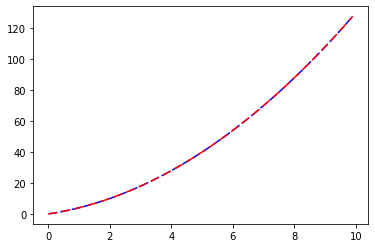

In [27]:

# my_y = [x_tree.evaluate(x_val=i , node = x_tree.root) for i in range(0,10) ]
# plt.plot([i for i in range(0,10)]  , my_y, color='b', dashes=[6, 2])

x_period  =  [x  for x in np.arange(0,10,0.1)] 
my_y = [x_tree.evaluate(x_val=i , node = x_tree.root) for i in x_period  ]
plt.plot(x_period , my_y, color='b', dashes=[6, 2])
plt.plot( x_period, sample_values["outputs"], color='r', dashes=[6, 3])
plt.show()

In [101]:
print("i:        my output:      real output:")
print("======================================")
for i in sample_values["x"]:
    i = float(i)
    print(f"{i}         {x_tree.evaluate(x_val=i , node = x_tree.root)}             ")#",sample_values["outputs"][i]  )

i:        my output:      real output:
0.0         0.0             
0.1         0.0019583336543291807             
0.2         0.009555556811392307             
0.30000000000000004         0.02537500113248825             
0.4         0.052000001072883606             
0.5         0.0920138880610466             
0.6000000000000001         0.14800000190734863             
0.7000000000000001         0.22254164516925812             
0.8         0.3182222545146942             
0.9         0.4376250207424164             
1.0         0.5833333134651184             
1.1         0.7579306364059448             
1.2000000000000002         0.9640000462532043             
1.3         1.204124927520752             
1.4000000000000001         1.480888843536377             
1.5         1.796875             
1.6         2.1546669006347656             
1.7000000000000002         2.556847333908081             
1.8         3.00600004196167             
1.9000000000000001         3.5047078132629395         